In [18]:
!pip install scikit-optimize

In [2]:
import boto3
from botocore.exceptions import ClientError


bucket = 'sleep-quality-forecast-bucket'
key = 'processed/sleep_data_clean.csv'
s3 = boto3.client('s3')

In [3]:
import pandas as pd
from io import StringIO

# Load cleaned data
obj = s3.get_object(Bucket=bucket, Key=key)
df = pd.read_csv(obj['Body'])
df.head()

,SESSION_DATE,SLEEP_SCORE,USAGE_HOURS,AHI,MASK_SESSION_COUNT,LEAK_50_PERCENTILE,LEAK_70_PERCENTILE,LEAK_95_PERCENTILE,DAY_OF_WEEK
0,2023-05-11,96,9.95,0.1,5,0.0,0.0,0.0,Thursday
1,2023-05-12,96,10.73,0.5,5,0.0,0.0,0.0,Friday
2,2023-05-13,98,10.22,0.3,4,0.0,0.0,0.0,Saturday
3,2023-05-14,100,9.97,0.3,2,0.0,0.0,0.0,Sunday
4,2023-05-15,95,8.80,0.6,6,0.0,0.0,0.0,Monday


In [20]:
X = df[['USAGE_HOURS', 'AHI', 'MASK_SESSION_COUNT',
        'LEAK_50_PERCENTILE', 'LEAK_70_PERCENTILE', 'LEAK_95_PERCENTILE']]
y = df['SLEEP_SCORE']

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=41
)

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error

base_model = RandomForestRegressor(n_estimators=100, random_state=41)

base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

results = {
    "R2": r2_score(y_test, y_pred),
    "RMSE": root_mean_squared_error(y_test, y_pred)
}

print("Base R^2:", r2_score(y_test, y_pred))
print("Base RMSE:", root_mean_squared_error(y_test, y_pred))

Base R^2: 0.9887290259157198
Base RMSE: 0.3137461201464916


In [27]:
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

search_spaces = {
    'n_estimators': Integer(100, 600),
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'max_features': Categorical(['sqrt', 'log2'])
}

bayes_cv = BayesSearchCV(
    estimator=RandomForestRegressor(n_estimators=100, random_state=41),
    search_spaces=search_spaces,
    n_iter=30,            # number of parameter settings to try
    scoring='r2',         # optimize r^2
    cv=3,                 # 3 fold crossvalidation
    n_jobs=-1,            # parallel jobs
    random_state=41,
    verbose=2
)

In [28]:
# ─────────── Run the optimization ───────────
print("Starting Bayesian hyperparameter search...")
bayes_cv.fit(X_train, y_train)

Starting Bayesian hyperparameter search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 fol

,estimator,RandomForestR...ndom_state=41)
,search_spaces,"{'max_depth': Integer(low=5...m='normalize'), 'max_features': Categorical(c...), prior=None), 'min_samples_leaf': Integer(low=1...m='normalize'), 'min_samples_split': Integer(low=2...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,30
,scoring,'r2'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,3


In [29]:
# ─────────── Show best hyperparameters and score ───────────
print("Best hyperparameters found:", bayes_cv.best_params_)
print("Best cross-validation R² (mean over folds):", bayes_cv.best_score_)

Best hyperparameters found: OrderedDict({'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100})
Best cross-validation R² (mean over folds): 0.8588375473014788


Test set R2: 0.9905784639440196
Test set RMSE: 0.28685240512427523


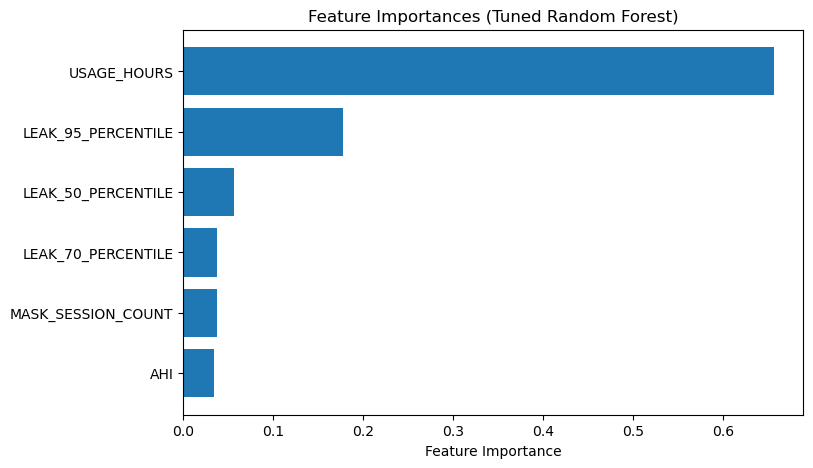

[CV] END max_depth=6, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=575; total time=   1.0s
[CV] END max_depth=25, max_features=log2, min_samples_leaf=3, min_samples_split=4, n_estimators=272; total time=   0.6s
[CV] END max_depth=27, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=558; total time=   0.8s
[CV] END max_depth=19, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=575; total time=   0.8s
[CV] END max_depth=19, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=575; total time=   0.8s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=484; total time=   1.0s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=484; total time=   0.7s
[CV] END max_depth=28, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=106; total time=   0.2s
[CV] END max_depth=7, max_features=log2, 

In [33]:
import matplotlib.pyplot as plt
import numpy as np

#evaluate new model on testing set
best_model = bayes_cv.best_estimator_
y_pred = best_model.predict(X_test)
print("Test set R2:", r2_score(y_test, y_pred))
print("Test set RMSE:", root_mean_squared_error(y_test, y_pred))

# show feature importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]  # sort descending

plt.figure(figsize=(8,5))
plt.barh([X.columns[i] for i in indices], importances[indices])
plt.xlabel("Feature Importance")
plt.title("Feature Importances (Tuned Random Forest)")
plt.gca().invert_yaxis()
plt.show()

In [34]:
import joblib

joblib.dump(best_model, "rf_bayesian_tuned_model.pkl")

['rf_bayesian_tuned_model.pkl']

In [35]:
#export to S3
bucket_name = 'sleep-quality-forecast-bucket'
model_key = 'models/rf_bayesian_tuned_model.pkl'

# Upload the file
s3.upload_file('rf_bayesian_tuned_model.pkl', bucket_name, model_key)

print(f"Model uploaded to {bucket_name}/{model_key}")

Model uploaded to sleep-quality-forecast-bucket/models/rf_bayesian_tuned_model.pkl
